In [105]:
# much of this code, particularly the encoder decoder code, is taken from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
# the rest is adapted for this project but is still pretty similar

from io import open
import unicodedata
import string
import re
import random
import os

import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

In [2]:
# for start and end of string
SOS_token = 0
EOS_token = 1

# Alphabet class (works with both pinyin and English)
class Alphabet:
    def __init__(self, name):
        self.name = name
        self.letter2index = {}
        self.letter2count = {}
        self.index2letter = {0: "SOS", 1: "EOS"}
        self.n_letters = 2
        
    def add_name(self, name):
        """
        Adds the characters of a name to the alphabet by iterating over them
        and updating the appropriate counts
        """
        if self.name.lower() == "pinyin": # for pinyin we can use the syllables instead of the raw letters. 
            name = name.split(" ")        # they'll still fall into the "letter" category though
            
        for letter in name: 
            if letter not in self.letter2index:
                self.letter2index[letter] = self.n_letters
                self.letter2count[letter] = 1
                self.index2letter[self.n_letters] = letter
                self.n_letters += 1
            else:
                self.letter2count[letter] += 1

                    
            


In [3]:
data_file = os.path.join("..", "data", "EnglishChineseNames_uniq.txt")

def normalize(s):
    """
    Right now just converts a string to lowercase but could be something more later
    (such as removing spaces)
    """
    s = re.sub(r"([-.·])", r"", s) # remove punctuation that seems to have seeped in (including chinese dash)
    return s.lower()

def read_alphabets():
    """
    Creates two alphabets, one for English / Romanized names and the other for pinyin
    Iterates through data file to initialize those alphabets
    """
    input_alph = Alphabet("English")
    output_alph = Alphabet("Pinyin")
    pairs = []
    
    df = pd.read_csv(data_file)
    for row_i, row in df.iterrows():
        english, _, _, pinyin = row
        english = normalize(english)
        pinyin = normalize(pinyin)
        input_alph.add_name(english)
        output_alph.add_name(pinyin) # includes spaces
        pairs.append([english, pinyin])
     
    print("Input names have: {} characters".format(input_alph.n_letters))
    print("Output names have: {} characters".format(output_alph.n_letters))


    return input_alph, output_alph, pairs
        
eng_alph, pin_alph, pairs = read_alphabets()

Input names have: 28 characters
Output names have: 279 characters


In [83]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Embedding is really just a lookup table that takes an index input and returns some k-dimensional vector
        # input_size is size of table, hidden size is number of weights associated with each vector. We really only
        # need this to be a one-hot vector for our purposes so we can probably don't need to explicity represent an 
        # embedding. The smaller our embedding dimension the more information we're giving up
        self.embedding = nn.Embedding(input_size, hidden_size) 
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)#, device=device)

In [5]:
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # still need an embedding
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # assume because we have 1-d data
        
    def forward(self, x, hidden):
        output = self.embedding(x).view(1, 1, -1)
        output = F.relu(output) # regularization thing
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0])) # output is only going to have a single thing, so this is legal i guess
        return output, hidden
     

In [27]:
def indexesFromName(alphabet, name):
    if alphabet.name.lower() == "english":
        return [alphabet.letter2index[l] for l in name]
    else:
        return [alphabet.letter2index[l] for l in name.split(" ")]

def tensorFromName(alphabet, name):
    indexes = indexesFromName(alphabet, name)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromName(eng_alph, pair[0])
    target_tensor = tensorFromName(pin_alph, pair[1])
    return (input_tensor, target_tensor)


In [88]:
# how often we use the target input as input to our decoder rather than our decoder's guess
# while training 
teacher_forcing_ratio = 0.5 
MAX_LENGTH = 20


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer,
         criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden() # just 0's
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)
    
    loss = 0 # mission accomplished ;)
    
    # actually run the thing that encodes
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        
    
    # now its decoder time - this part changes somewhat if you add attention
    decoder_input = torch.tensor([[SOS_token]])
    decoder_hidden = encoder_hidden # no need for an init function
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # target is next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di] # bc we're using teacher focing
            
    else:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1) # returns a tuple of the largest value and its index as tensors
            decoder_input = topi.squeeze().detach() # I'm not totally sure what this does
            loss += criterion(decoder_output, target_tensor[di])
            
            if decoder_input.item() == EOS_token:
                break # we're done with this sentence - we don't have to do this above bc it goes to the end of the string automatically
    
    
    # backprop
    loss.backward()
    
    # run SGD which is in the encoder/decoder_optimizer object
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/target_length # not sure what this is, but we can see I guess


In [19]:
# copied directly for profiling...
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [20]:
# Actually do the training:

def trainIters(encoder, decoder, training_pairs, n_iters, print_every=1000, plot_every=100, learning_rate = 0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(training_pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss() # this is... negative log likelihood loss
                             # it's the same as cross-entropy loss bc of the log softmax in the last layer
    
    for iter_i in range(1, n_iters + 1):
        training_pair = training_pairs[iter_i -1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter_i % print_every == 0:
            print_loss_avg = print_loss_total / print_every # calc avg loss
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter_i / n_iters),
                                         iter_i, iter_i / n_iters * 100, print_loss_avg))
        # for plotting loss
        if iter_i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [21]:
%matplotlib inline

#shamelessly copied from tutorial... yikes
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [112]:
# Same as training, just no targets - just rum the thing through the network

# Same as training, just no targets - just rum the thing through the network

def evaluate(encoder, decoder, name, max_len=MAX_LENGTH, target_name=None):
    with torch.no_grad(): # not totally sure what this does tbh - probably stops from updating gradients like we do in training because we are done with training
        input_tensor = tensorFromName(eng_alph, name)
        input_length = input_tensor.size(0) # just the size of the first dimension
        if target_name is not None:
            target_tensor = tensorFromName(pin_alph, target_name)
            target_length = target_tensor.size(0)
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_len, encoder.hidden_size)
        criterion = nn.NLLLoss()
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0] # is a vector 
        
        # decoder - would have to change if added attention
        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden = encoder_hidden
        decoded_name = []
        loss = 0
        if target_name is not None:
            max_len = min(target_length, max_len)
            
        for di in range(max_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            if target_name is not None:
                loss += criterion(decoder_output, target_tensor[di])
            
            # transliterate to actual words 
            if topi.item() == EOS_token:
                decoded_name.append("<EOS>")
                break
            else:
                decoded_name.append(pin_alph.index2letter[topi.item()])
            
            decoder_input = topi.squeeze().detach()
        
        if target_name is not None:
            #pass
            print("Loss = ", loss)
          
        return decoded_name, loss


# def evaluate(encoder, decoder, name, max_len=MAX_LENGTH):
#     with torch.no_grad(): # not totally sure what this does tbh - probably stops from updating gradients like we do in training because we are done with training
#         input_tensor = tensorFromName(eng_alph, name)
#         input_length = input_tensor.size(0) # just the size of the first dimension
#         encoder_hidden = encoder.initHidden()
#         encoder_outputs = torch.zeros(max_len, encoder.hidden_size)
        
#         for ei in range(input_length):
#             encoder_output, encoder_hidden = encoder(
#                 input_tensor[ei], encoder_hidden)
#             encoder_outputs[ei] += encoder_output[0, 0] # is a vector 
        
#         # decoder - would have to change if added attention
#         decoder_input = torch.tensor([[SOS_token]])
#         decoder_hidden = encoder_hidden
#         decoded_name = []
        
#         for di in range(max_len):
#             decoder_output, decoder_hidden = decoder(
#                 decoder_input, decoder_hidden)
#             topv, topi = decoder_output.topk(1)
            
#             # transliterate to actual words 
#             if topi.item() == EOS_token:
#                 decoded_name.append("<EOS>")
#                 break
#             else:
#                 decoded_name.append(pin_alph.index2letter[topi.item()])
            
#             decoder_input = topi.squeeze().detach()
            
            
#         return decoded_name

In [117]:
def evaluateRandomLines(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_name, loss = evaluate(encoder, decoder, pair[0], target_name=pair[1])
        print('<', ''.join(output_name[:-1]))
        print()

In [118]:
evaluateRandomLines(encoder2, decoder2, 1)

> boyce
= bǎi yí sī
Loss =  tensor(5.6523)
< bàosīsī



In [119]:
def evaluateAllLines(encoder, decoder, eval_pairs, spaces = False):
    distance = 0
    diff_count = 0
    total_loss = 0
    for pair in eval_pairs:
        output_name, loss = evaluate(encoder, decoder, pair[0], target_name=pair[1])
        total_loss += loss
        # maintain spaces
        if spaces:
            output_name  = ''.join(output_name[:-1])
            target_name = pair[1]
            print(output_name, target_name)
        else:
            # remove the space for edit distance calculations for consistency with baseline
            output_name = ''.join(filter(lambda l: l != ' ', output_name[:-1])) # need to get rid of the <EOS> string at end
            target_name = ''.join(filter(lambda l: l != ' ', pair[1]))
        if output_name != target_name:
            
            diff_count += 1
            distance += edit_distance_pinyin(target_name, output_name)
    print("Out of {} names, {} were different, with an average edit distance of {} ({} for just the different pairs)".format(len(eval_pairs), diff_count, distance/len(eval_pairs), distance/diff_count))
    print("Average Loss was {}".format(total_loss/len(eval_pairs)))

#def evaluateAllLines(encoder, decoder, eval_pairs, spaces = False):
#     distance = 0
#     diff_count = 0
#     for pair in eval_pairs:
#         output_name = evaluate(encoder, decoder, pair[0])
        
#         # maintain spaces
#         if spaces:
#             output_name  = ''.join(output_name[:-1])
#             target_name = pair[1]
#             print(output_name, target_name)
#         else:
#             # remove the space for edit distance calculations for consistency with baseline
#             output_name = ''.join(filter(lambda l: l != ' ', output_name[:-1])) # need to get rid of the <EOS> string at end
#             target_name = ''.join(filter(lambda l: l != ' ', pair[1]))
#         if output_name != target_name:
            
#             diff_count += 1
#             distance += edit_distance_pinyin(target_name, output_name)
#     print("Out of {} names, {} were different, with an average edit distance of {} ({} for just the different pairs)".format(len(eval_pairs), diff_count, distance/len(eval_pairs), distance/diff_count))


In [85]:
def train_and_evaluate(encoder, decoder):
    english_names = [pair[0] for pair in pairs]
    pinyin_names = [pair[1] for pair in pairs]
    train_eng, test_eng, train_pin, test_pin = train_test_split(english_names, pinyin_names, test_size=100)
    train_pairs = list(zip(train_eng, train_pin))
    test_pairs = list(zip(test_eng, test_pin))
    trainIters(encoder, decoder, train_pairs, 75000, print_every=5000)
    
    evaluateAllLines(encoder, decoder, test_pairs)
    return train_pairs, test_pairs
    

In [120]:
evaluateAllLines(encoder2, decoder2, [('golrokh', '')], spaces = True)

KeyError: ''

0m 25s (- 6m 2s) (5000 6%) 3.4219
0m 47s (- 5m 11s) (10000 13%) 3.2280
1m 9s (- 4m 39s) (15000 20%) 2.9688
1m 32s (- 4m 13s) (20000 26%) 2.7145
1m 55s (- 3m 50s) (25000 33%) 2.4897
2m 17s (- 3m 26s) (30000 40%) 2.3016
2m 40s (- 3m 3s) (35000 46%) 2.1116
3m 3s (- 2m 40s) (40000 53%) 1.9271
3m 25s (- 2m 17s) (45000 60%) 1.8009
3m 48s (- 1m 54s) (50000 66%) 1.6440
4m 10s (- 1m 31s) (55000 73%) 1.5587
4m 32s (- 1m 8s) (60000 80%) 1.4444
4m 55s (- 0m 45s) (65000 86%) 1.3468
5m 17s (- 0m 22s) (70000 93%) 1.2561
5m 40s (- 0m 0s) (75000 100%) 1.1927


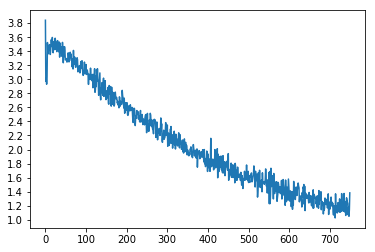

Out of 100 names, 93 were different, with an average edit distance of 3.795 (4.080645161290323 for just the different pairs)


In [89]:
# now actually do the thing!
hidden_size = eng_alph.n_letters
encoder2 = EncoderRNN(eng_alph.n_letters, hidden_size)
decoder2 = DecoderRNN(hidden_size, pin_alph.n_letters)

train_set, test_set = train_and_evaluate(encoder2, decoder2)
#trainIters(encoder2, decoder2, 75000, print_every=5000)

In [122]:
evaluateAllLines(encoder2, decoder2, test_set, spaces = False)

Loss =  tensor(30.6239)
Loss =  tensor(16.3986)
Loss =  tensor(6.5815)
Loss =  tensor(11.3915)
Loss =  tensor(1.8326)
Loss =  tensor(13.2649)
Loss =  tensor(10.1928)
Loss =  tensor(2.4712)
Loss =  tensor(15.0221)
Loss =  tensor(20.7955)
Loss =  tensor(12.4677)
Loss =  tensor(14.2011)
Loss =  tensor(15.2266)
Loss =  tensor(2.7897)
Loss =  tensor(22.9438)
Loss =  tensor(13.5468)
Loss =  tensor(6.9521)
Loss =  tensor(14.6436)
Loss =  tensor(10.0947)
Loss =  tensor(7.7440)
Loss =  tensor(0.6744)
Loss =  tensor(6.2406)
Loss =  tensor(1.6703)
Loss =  tensor(11.8615)
Loss =  tensor(11.1750)
Loss =  tensor(17.3431)
Loss =  tensor(15.0114)
Loss =  tensor(8.6609)
Loss =  tensor(17.1692)
Loss =  tensor(16.5499)
Loss =  tensor(8.7968)
Loss =  tensor(1.9974)
Loss =  tensor(7.9596)
Loss =  tensor(3.3015)
Loss =  tensor(14.2220)
Loss =  tensor(7.6585)
Loss =  tensor(8.4760)
Loss =  tensor(4.2564)
Loss =  tensor(21.9266)
Loss =  tensor(8.8419)
Loss =  tensor(2.0153)
Loss =  tensor(3.9385)
Loss =  tens

In [74]:
evaluateRandomLines(encoder2, decoder2, 10)

> sampson
= xīn pǔ sēn
< shāmǔsēn

> boyd
= bù dé
< bùdé

> bernice
= bǎi nī sī
< bùlánní

> denise
= dān nī sī
< wéinísī

> martina
= mǎ dì nà
< mǎdìnà

> maurice
= mó lǐ sī
< mǎlǐsī

> cathy
= kǎi xī
< kǎixī

> janice
= zhān nī sī
< zhēnnīsī

> flora
= fú luō lā
< fúlālā

> trina
= cuī nà
< tètènà



In [101]:
import datetime
def save_model(encoder, decoder):
    torch.save(encoder.state_dict(), os.path.join("..", "models", "{date:%Y-%m-%d-%H:%M:%S}-encoder".format(date=datetime.datetime.now())))
    torch.save(decoder.state_dict(), os.path.join("..", "models", "{date:%Y-%m-%d-%H:%M:%S}-decoder".format(date=datetime.datetime.now())))

save_model(encoder2, decoder2)

In [84]:
def load_model(encoder_path, decoder_path):
    encoder1 = EncoderRNN(eng_alph.n_letters, hidden_size)
    decoder1 = DecoderRNN(hidden_size, pin_alph.n_letters)
    encoder1.load_state_dict(torch.load(encoder_path))
    decoder1.load_state_dict(torch.load(decoder_path))
    return encoder1, decoder1

'abcde'

In [32]:
sorted(pin_alph.index2letter.values())

['EOS',
 'SOS',
 'bo',
 'bài',
 'bào',
 'bái',
 'bèi',
 'bì',
 'bó',
 'bù',
 'bā',
 'bān',
 'bāng',
 'běn',
 'bīn',
 'bō',
 'bǎi',
 'bǎo',
 'bǐ',
 'chá',
 'chè',
 'cuì',
 'cuī',
 'cài',
 'de',
 'diān',
 'duō',
 'dà',
 'dài',
 'dào',
 'dá',
 'dèng',
 'dé',
 'dì',
 'dí',
 'dù',
 'dùn',
 'dān',
 'dāng',
 'dēng',
 'dī',
 'dīng',
 'dōng',
 'dōu',
 'dū',
 'dūn',
 'fàn',
 'fán',
 'fèi',
 'fù',
 'fú',
 'fāng',
 'fēi',
 'fēn',
 'fěi',
 'fū',
 'fǎ',
 'guān',
 'guǒ',
 'gài',
 'gè',
 'gé',
 'gān',
 'gāo',
 'gē',
 'gēn',
 'gū',
 'gǔ',
 'huá',
 'huò',
 'hàn',
 'hán',
 'háo',
 'hè',
 'hé',
 'hú',
 'hā',
 'hēng',
 'hū',
 'hǎi',
 'hǎn',
 'hǎo',
 'jié',
 'jiā',
 'jiǎ',
 'jiǎn',
 'jì',
 'jí',
 'jī',
 'jīn',
 'kuí',
 'kè',
 'kòu',
 'kù',
 'kāng',
 'kē',
 'kě',
 'kěn',
 'kūn',
 'kǎ',
 'kǎi',
 'kǎn',
 'kǎo',
 'lián',
 'liáng',
 'liè',
 'luò',
 'luó',
 'luō',
 'lài',
 'lái',
 'lán',
 'láo',
 'lè',
 'léi',
 'lì',
 'lìlù',
 'lín',
 'líng',
 'lóng',
 'lù',
 'lú',
 'lún',
 'lüè',
 'lā',
 'lēi',
 'lěi',
 'lǎng',


In [53]:
#df = pd.read_csv(data_file)
max([len(x) for x in df['first name']])

11

In [37]:
"../models/decoder-2018-11-14-23:32:47"

AttributeError: 'Series' object has no attribute 'contains'

In [29]:
# specifically for pinyin - doesn't penalize wrong tones as much
def edit_distance_pinyin(str1, str2):
    cache = {}
    def recurse(str1, str2):
        # base cases
        if len(str1) == 0:
            return len(str2)
        elif len(str2) == 0:
            return len(str1)
        
        if cache.get((str1, str2), -1) != -1:
            return cache[(str1, str2)]
        # recursive case
        if str1[0] == str2[0]:
            ed = recurse(str1[1:], str2[1:])
            cache[(str1, str2)] = ed
            return ed
        if have_diff_tones(str1[0], str2[0]):
            ed = 0.5 + recurse(str1[1:], str2[1:])
            cache[(str1, str2)] = ed
            return ed
        else:
            # min of insert into 1, insert into 2, replace
            ed = 1 + min(recurse(str1, str2[1:]), recurse(str1[1:], str2), recurse(str1[1:], str2[1:]))
            cache[(str1, str2)] = ed
            return ed

    return recurse(str1, str2) #- common_chars(str1, str2)

In [30]:
# specifically for pinyin 
def have_diff_tones(v1, v2):
    result = False
    if v1 in 'āáǎàa' and v2 in 'āáǎàa':
        return True
    elif v1 in 'ēéěèe' and v2 in 'ēéěèe':
        return True
    elif v1 in 'īíǐìi' and v2 in 'īíǐìi':
        return True
    elif v1 in 'ōóǒòo' and v2 in 'ōóǒòo':
        return True
    elif v1 in 'ūúǔùu' and v2 in 'ūúǔùu':
        return True
    elif v1 in 'ǖǘǚǜü' and v2 in 'ǖǘǚǜü':
        return True
    else:
        return False

In [31]:
edit_distance_pinyin('ben', 'běn')

0.5